# Summary

## The Data 💾

<p style="font-size:18px">This dataset contains a large amount of benign melanoma images compared to malignant melanoma. However, since this is a binary classification task, discarding all images other than benign melanoma as malignant melanoma is sufficient.</p>

### The metadata 


## Method

<p style="font-size:18px">
    The method proposed in this notebook was to use a resnet50 pre-trained model to extract features from the images and use a technique of multisample dropout in the classifier layer. The multisample dropout method you can find it in the paper <a href="https://arxiv.org/abs/1905.09788">"Multi-sample dropout for accelerated training and better generalization"</a>
</p>

In [1]:
import numpy as np 
import pandas as pd
import os
import time
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
sns.set_style("darkgrid")

# PyTorch

import torch as T
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

Configure GPU

In [2]:
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

## Loading Train Dataset

In [3]:
base_path = "/kaggle/input/siim-isic-melanoma-classification"

In [4]:
# Read data
train_dataset = pd.read_csv(f"{base_path}/train.csv")
# Dataset dimensions
print(f"Shape of the dataset: {train_dataset.shape}")
# Dataset memory usage
print('Dataset Memory Usage = {:.2f} MB'.format(train_dataset.memory_usage().sum() / 1024**2))
# Show data sample
train_dataset.head()

Shape of the dataset: (33126, 8)
Dataset Memory Usage = 2.02 MB


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [10]:
train_dataset = train_dataset.loc[:70, :]

# Exploratory Data Analysis

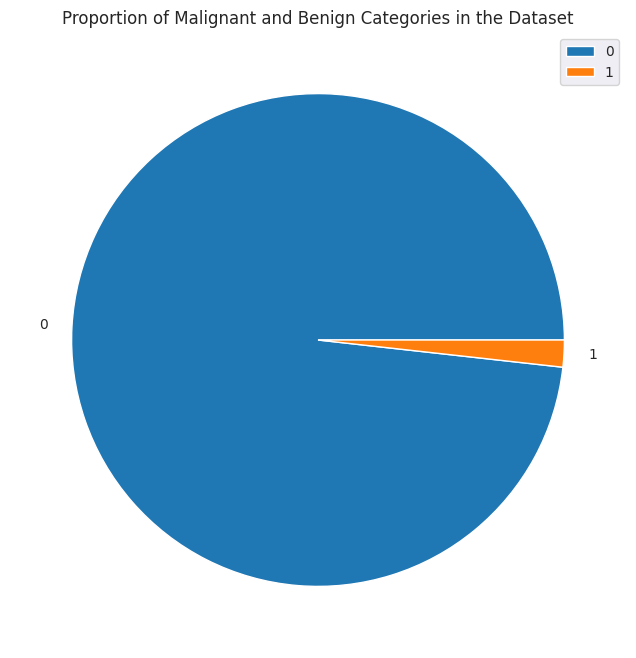

In [5]:
train_dataset['target'].value_counts().plot(kind='pie', figsize=(8,8))
plt.title("Proportion of Malignant and Benign Categories in the Dataset")
plt.ylabel("")
plt.legend()

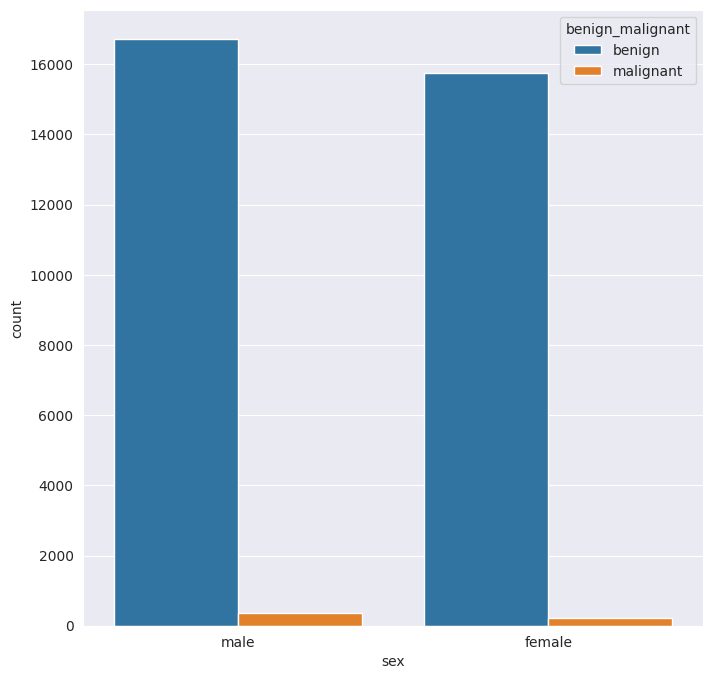

In [6]:
plt.figure(figsize=(8,8))
sns.countplot(data=train_dataset, x='sex', hue='benign_malignant')
plt.show()

## Remove target redundant column

In [5]:
train_dataset = train_dataset.drop(['benign_malignant'], axis = 1)

### Missing values

<Axes: >

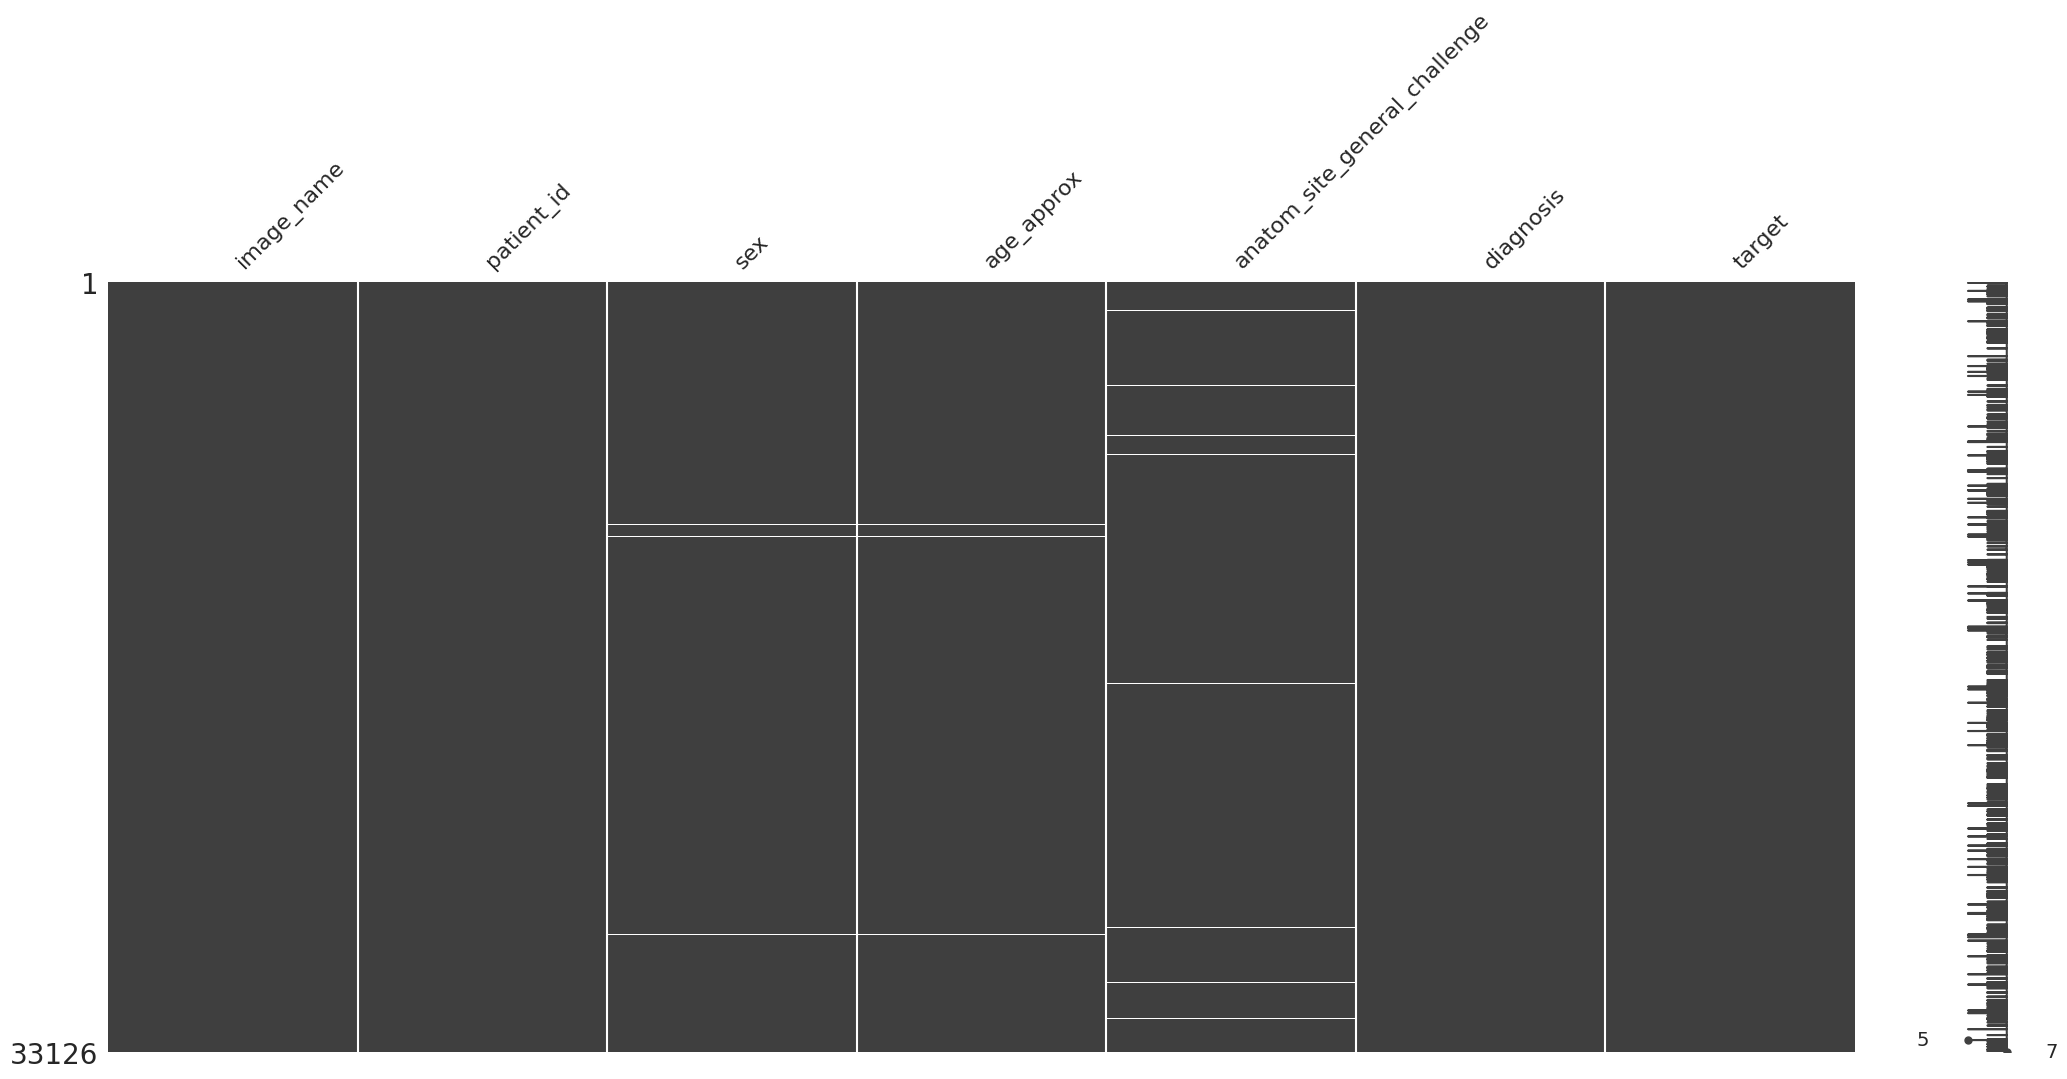

In [8]:
msno.matrix(train_dataset)

In [9]:
# Count of missing values
print("Count of missing values by columns: \n")
train_dataset.isna().sum().sort_values(ascending=False)

Count of missing values by columns: 



anatom_site_general_challenge    527
age_approx                        68
sex                               65
patient_id                         0
image_name                         0
diagnosis                          0
target                             0
dtype: int64

## Dataset samples

In [ ]:
images = train_dataset.loc[train_dataset['target']==1].sample(10)['image_name'].values
plt.figure(figsize=(16,8))
for idx, image_name in enumerate(images):
    image = Image.open(f"/kaggle/input/siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg")    
    plt.subplot(2,5, idx+1)
    plt.axis('off')
    plt.imshow(image)
plt.suptitle("Images with Malignt Melanoma")
plt.show()

In [ ]:
images = train_dataset.loc[train_dataset['target']==0].sample(10)['image_name'].values
plt.figure(figsize=(16,8))
for idx, image_name in enumerate(images):
    image = Image.open(f"/kaggle/input/siim-isic-melanoma-classification/jpeg/train/{image_name}.jpg")
    plt.subplot(2,5, idx+1)
    plt.axis('off')
    plt.imshow(image)
plt.suptitle("Images with Benign Melanoma")
plt.show()

## Create Melanoma Dataset

In [5]:
class Melanoma_Dataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, imfolder: str, split: str, transforms = None, meta_features = None):
        self.df = df
        self.imfolder = imfolder
        self.split = split
        self.transforms = transforms
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        # Path of the images
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        # Read image
        x = Image.open(im_path)        
        # Read meta features associated to the image
        #meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)       
        # Apply transformations to the image        
        if self.transforms:            
            x = self.transforms(x)            
        # Get the numerical target label (0->benign, 1->malign) 
        if self.split != 'test':
            y = self.df.iloc[index]['target']
            return x, y
        else:
            # For test data
            return x
    def __len__(self):
        # Return the length of the DataFrame
        return len(self.df)

## Model architecture

In [6]:
class Model(nn.Module):
    
    def __init__(self, resnet50_model):
        super(Model,self).__init__()        
        
        self.resnet50_model = resnet50_model        
        
        # Multisample dropout stream        
        self.output = nn.Sequential(
            nn.BatchNorm1d(2048),
            nn.Dropout(0.3),
            nn.Linear(2048,2)            
        )
        
        self.to(device)
        # Optimizer 
        self.optim_classifier = T.optim.Adam(self.output.parameters(), lr=0.001)
        
        # Loss
        self.criterion = T.nn.CrossEntropyLoss()
        # Scheduler
        self.scheduler_classifier = T.optim.lr_scheduler.StepLR(self.optim_classifier, step_size=7, gamma=0.1)
        
        
    def forward(self, x):
        
        X_common = self.resnet50_model(x)
        X_common = X_common.view(X_common.size(0), -1)
        
        P1 = self.output(X_common)
        P2 = self.output(X_common)
        P3 = self.output(X_common)
        P4 = self.output(X_common)
        P5 = self.output(X_common)
        P6 = self.output(X_common)
                        
        return [P1, P2, P3, P4, P5, P6]
    
    def get_weights(self):
        return self.output.state_dict()
    
    def load_weights(self, weights):
        self.output.load_state_dict(weights)

##  Data Augmentation

In [7]:
train_transforms = transforms.Compose([           
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([    
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Preprocessing Data

Split dataset

In [8]:
train, val = train_test_split(train_dataset, test_size=0.2, random_state=42)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [9]:
train_data = Melanoma_Dataset(
    df=train,
    imfolder=f'{base_path}/jpeg/train/',
    split='train',
    transforms=train_transforms
)
validation_data = Melanoma_Dataset(
    df=val,
    imfolder=f'{base_path}/jpeg/train/',
    split='val',
    transforms=test_transforms
)

train_dl = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
validation_dl = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4)

In [10]:
print(f"Train data length: {len(train_dl.dataset)}, Validation data length: {len(validation_dl.dataset)}")

Train data length: 26500, Validation data length: 6626


# Training

## Training function

In [11]:
def train_model(train_dl, val_dl, model, epochs=10):
    
    # history record        
    train_loss_history = []
    val_loss_history = []
    # Best validation accuracy
    best_val_loss = 0.0    
    # Get initial weights
    weights = model.get_weights()
    
    for epoch in range(epochs):
        print("="*20, "Epoch: ", str(epoch), "="*20)
        
        train_loss = 0
        
        val_loss = 0        
        
        # Set to training mode
        model.train()
        
        for x, y in train_dl:               
            # Convert data to Tensor            
            x = x.clone().detach().to(device).requires_grad_(True)            
            y = y.clone().detach().long().to(device)
            # Reset gradients            
            model.optim_classifier.zero_grad()
            # Predict
            preds = model(x)     
            
            # Compute the loss            
            loss_1 = model.criterion(preds[0],y)           
            loss_2 = model.criterion(preds[1],y)
            loss_3 = model.criterion(preds[2],y)
            loss_4 = model.criterion(preds[3],y)
            loss_5 = model.criterion(preds[4],y)
            loss_6 = model.criterion(preds[5],y)
            loss = (loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6) / 6
            # Compute the gradients            
            loss.backward()
            # Update weights            
            model.optim_classifier.step()           
            
            train_loss += loss.item()           
                
        model.scheduler_classifier.step()
               
        train_loss_history.append(train_loss)
        
        # Switch to evaluation mode
        model.eval()        
        
        with T.no_grad():
            for x, y in val_dl:                
                # Convert data to Tensor                
                x = x.clone().detach().to(device)                
                y = y.clone().detach().long().to(device)    
                # Predict
                preds = model(x)                                                     
                # Compute the loss            
                loss_1 = model.criterion(preds[0],y)           
                loss_2 = model.criterion(preds[1],y)
                loss_3 = model.criterion(preds[2],y)
                loss_4 = model.criterion(preds[3],y)
                loss_5 = model.criterion(preds[4],y)
                loss_6 = model.criterion(preds[5],y)
                loss = (loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6) / 6                
                
                val_loss += loss.item()
                
        val_loss_history.append(val_loss)           
        
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            weights = model.get_weights()
            
        print("Train Loss: {:.4f} | Validation Loss: {:.4f}".format(train_loss, val_loss))
    model.load_weights(weights)
    return [train_loss_history, val_loss_history], model

## Models

Resnet50 model

In [12]:
resnet50 = models.resnet50(pretrained=True)

resnet50_model = nn.Sequential(
    resnet50.conv1,
    resnet50.bn1,
    resnet50.relu,
    resnet50.maxpool,
    resnet50.layer1,
    resnet50.layer2,
    resnet50.layer3,
    resnet50.layer4,
    resnet50.avgpool
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [13]:
# Freeze parameters of pretrained models
for param in resnet50_model.parameters():    
    param.requires_grad = False

## Training model

In [14]:
model = Model(resnet50_model)

In [ ]:
history, model = train_model(train_dl, validation_dl, model)

==================== Epoch:  0 ====================
Train Loss: 58.5244 | Validation Loss: 9.5536
==================== Epoch:  1 ====================
Train Loss: 37.7632 | Validation Loss: 9.6150
==================== Epoch:  2 ====================


In [ ]:
img = cv2.imread("/kaggle/input/siim-isic-melanoma-classification/jpeg/train/ISIC_0099474.jpg", 1)
print(img.shape)
plt.imshow(img)

In [27]:
# Read data
test_dataset = pd.read_csv(f"{base_path}/test.csv")
# Dataset dimensions
print(f"Shape of the dataset: {test_dataset.shape}")
# Dataset memory usage
print('Dataset Memory Usage = {:.2f} MB'.format(test_dataset.memory_usage().sum() / 1024**2))
# Show data sample
test_dataset.head()

Shape of the dataset: (10982, 5)
Dataset Memory Usage = 0.42 MB


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [28]:
test_dataset = test_dataset.iloc[:70, :]

In [29]:
test_data = Melanoma_Dataset(
    df=test_dataset,
    imfolder=f'{base_path}/jpeg/test/',
    split='test',
    transforms=test_transforms
)

test_dl = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

In [30]:
# Switch to evaluation mode
model.eval()        

with T.no_grad():
    for x in test_dl:                
        # Convert data to Tensor                
        x = x.clone().detach().to(device)                        
        # Predict
        preds = model(x)                    

In [38]:
print(T.nn.functional.softmax(preds[0], dim=1)[:][1])

tensor([0.4281, 0.5719], device='cuda:0')
